<a href="https://colab.research.google.com/github/r-isachenko/2022-2023-DGM-MIPT-course/blob/main/seminars/seminar8/GAN_colab_with_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from time import time
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import torch.distributions as TD

# <center>Deep Generative Models</center>
## <center>Seminar 8</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>14.02.2023</center>

## Plan

. Vanilla GAN

# Vanilla GAN

<img src="pics/gan_objective.jpg" width=800 height=800 />

In [2]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1

    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_), nn.ReLU()])

    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))

    return nn.Sequential(*modules)

In [3]:
# define shallow nn
gen_hiddens = [1, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

In [4]:
####

In [5]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu + torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

In [6]:
def plot_gan_data(data_fn, noise_fn, data_pdf=None):
    noise = noise_fn(5000).numpy().flatten()
    target = data_fn(5000).numpy().flatten()

    plt.hist(noise, label='noise', alpha=0.5, density=True, color='b')
    plt.hist(target, label='target', alpha=0.5, density=True, color='g')
    if data_pdf is not None:
        x = np.linspace(-6,6,100)
        plt.plot(x, data_pdf(x), 'g', label='real distibution')

    plt.legend(loc='upper left')
    plt.show()

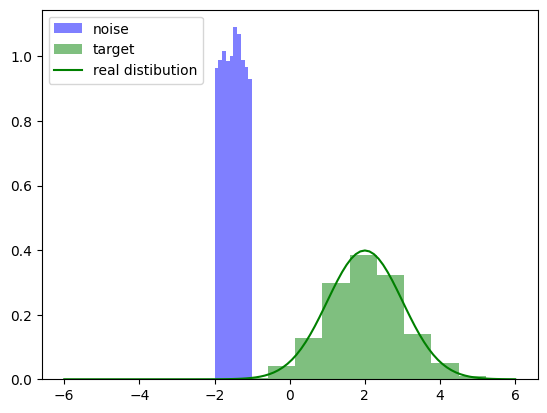

In [7]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [13]:
class VanillaGAN():

    def __init__(self, G, D, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_D=1e-3, lr_G=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            G: a Ganerator network
            D: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_D: learning rate for the discriminator
            lr_G: learning rate for the generator
        """
        self.G = G
        self.G = self.G.to(device)
        self.D = D
        self.D = self.D.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        # !
        self.criterion = nn.BCELoss()
        self.optim_D = optim.Adam(D.parameters(),
                                  lr=lr_D, betas=(0.5, 0.999))
        self.optim_G = optim.Adam(G.parameters(),
                                  lr=lr_G, betas=(0.5, 0.999))
        # is needed in D train loop
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
    
    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        ! We don't need grad for generated samples
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        # your code here
        with torch.no_grad():
            samples = self.G(latent_vec)
        return samples

    def train_step_G(self):
        """Train the generator one step and return the loss."""
        self.G.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        # your code here
        # use self.target_ones
        generated = self.G(latent_vec)
        classifications = self.D(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_G.step()
        return loss.item()

    def train_step_D(self):
        """Train the discriminator one step and return the losses."""
        self.D.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        # calc real loss
        # you code here
        pred_real = self.D(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        # calc fake loss
        # you shouldn't optimize G here
        # you code here
        
        with torch.no_grad():
            fake_samples = self.G(latent_vec)
        pred_fake = self.D(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_D.step()
        
        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D

In [14]:
gen_hiddens = [1, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')

In [15]:
def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

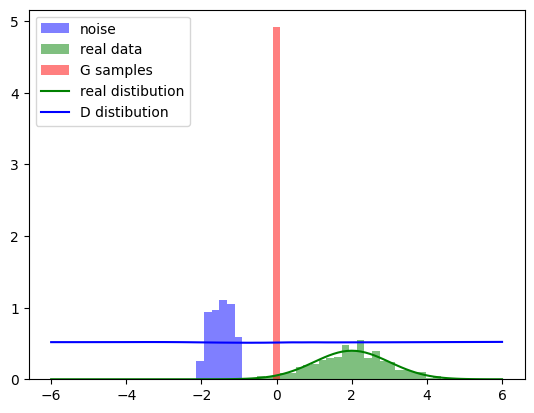

In [16]:
visualize_GAN(gan, data_pdf=data_pdf)

In [22]:
epochs = 50
batches = 100

Epoch 1/50 (0s): G=0.755, Dr=0.676, Df=0.665


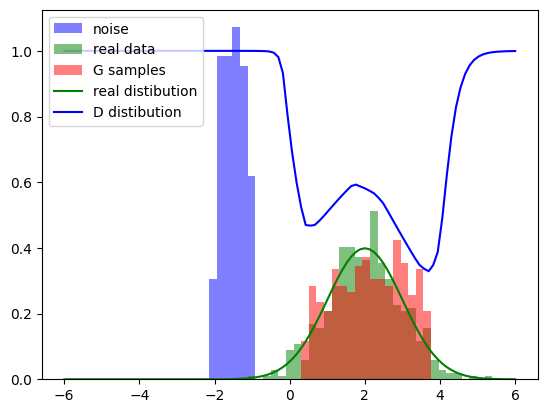

Epoch 2/50 (1s): G=0.763, Dr=0.671, Df=0.660


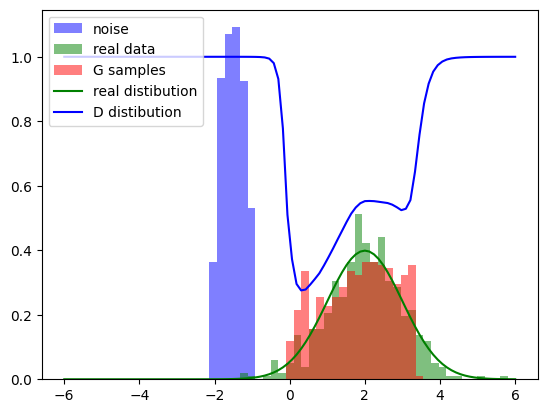

Epoch 3/50 (1s): G=0.761, Dr=0.674, Df=0.670


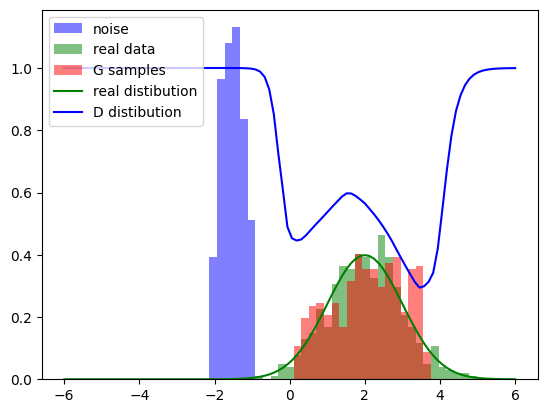

Epoch 4/50 (2s): G=0.753, Dr=0.675, Df=0.664


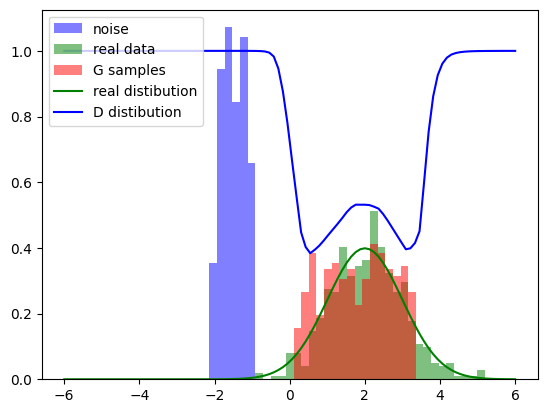

Epoch 5/50 (3s): G=0.770, Dr=0.666, Df=0.654


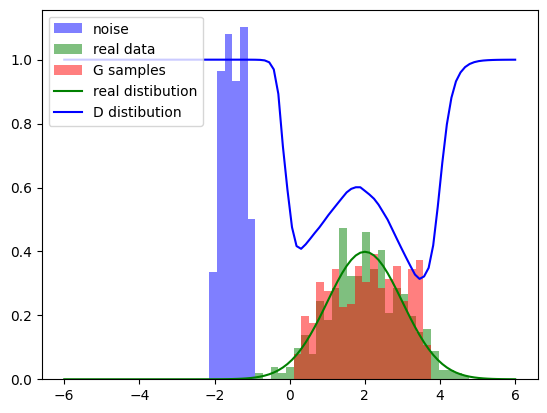

Epoch 6/50 (4s): G=0.769, Dr=0.668, Df=0.656


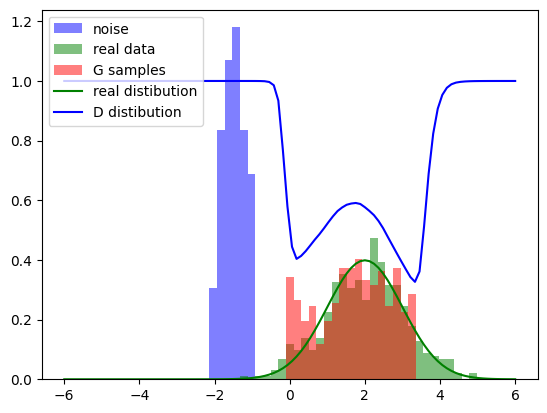

Epoch 7/50 (5s): G=0.760, Dr=0.675, Df=0.666


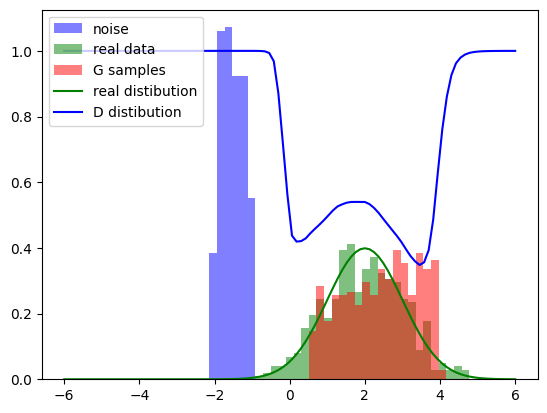

Epoch 8/50 (6s): G=0.752, Dr=0.674, Df=0.660


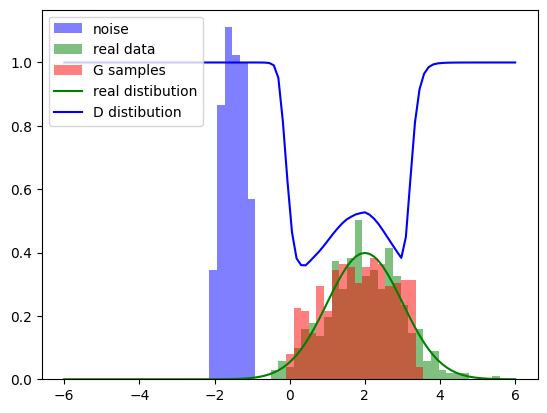

Epoch 9/50 (6s): G=0.767, Dr=0.676, Df=0.666


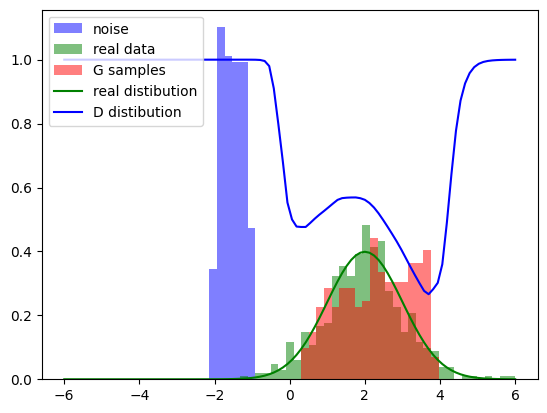

Epoch 10/50 (7s): G=0.749, Dr=0.677, Df=0.666


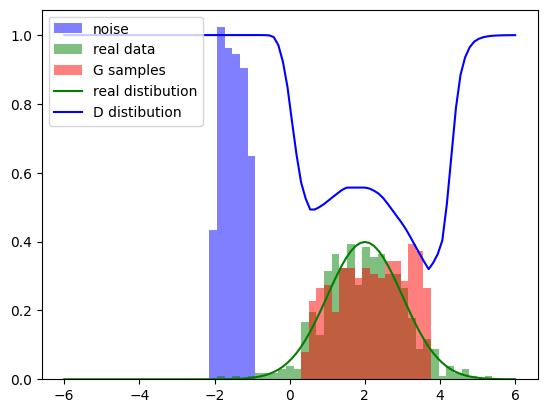

Epoch 11/50 (8s): G=0.760, Dr=0.674, Df=0.662


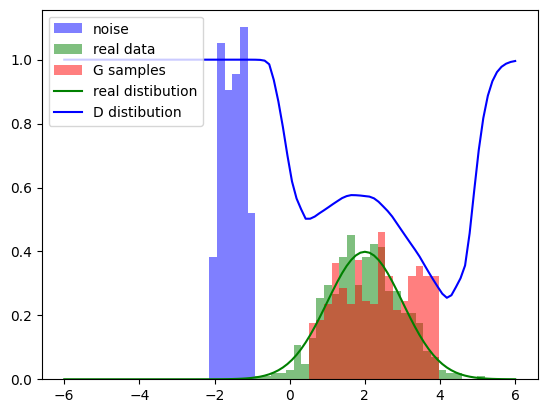

Epoch 12/50 (9s): G=0.735, Dr=0.678, Df=0.666


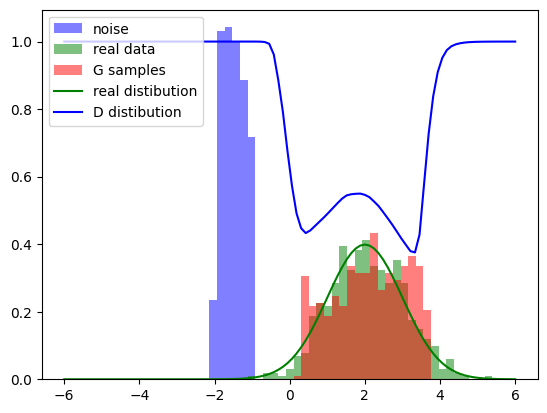

Epoch 13/50 (10s): G=0.766, Dr=0.673, Df=0.658


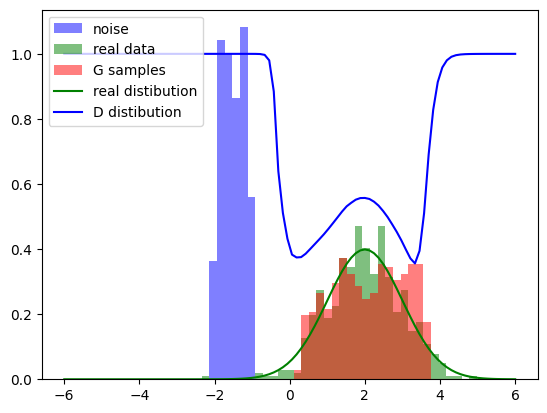

Epoch 14/50 (11s): G=0.753, Dr=0.672, Df=0.661


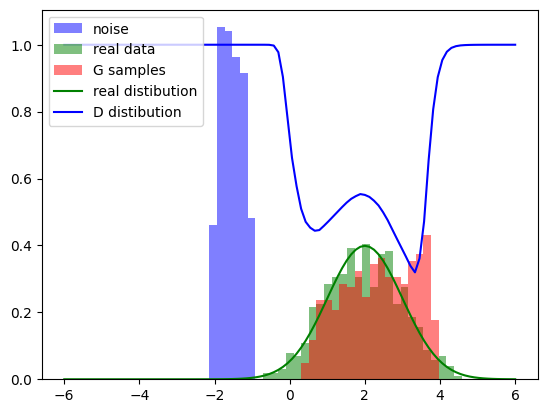

Epoch 15/50 (11s): G=0.749, Dr=0.676, Df=0.679


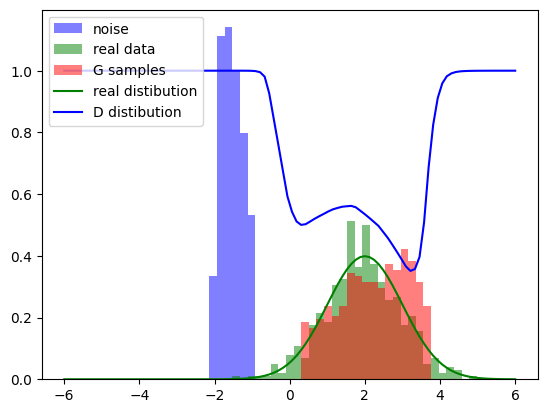

Epoch 16/50 (12s): G=0.785, Dr=0.682, Df=0.651


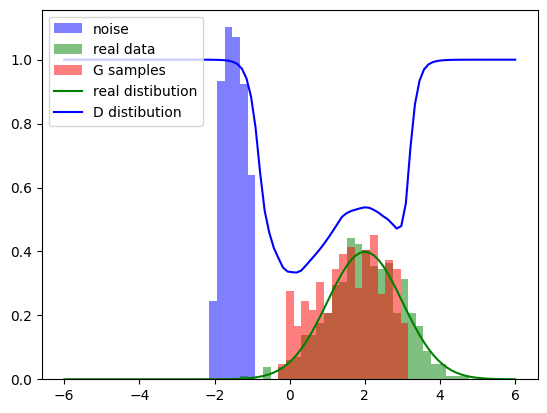

Epoch 17/50 (13s): G=0.732, Dr=0.672, Df=0.674


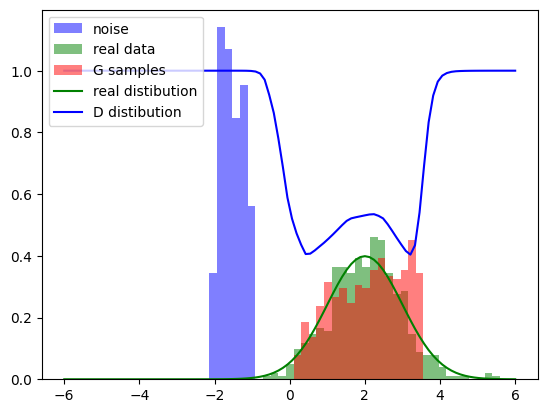

Epoch 18/50 (14s): G=0.753, Dr=0.672, Df=0.666


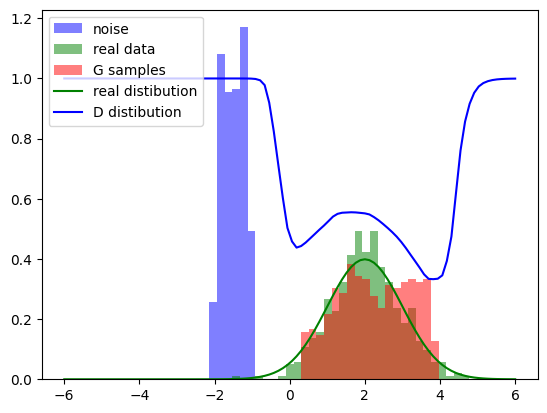

Epoch 19/50 (15s): G=0.743, Dr=0.673, Df=0.667


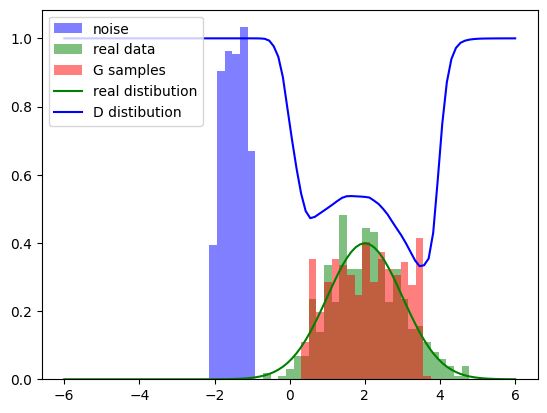

Epoch 20/50 (16s): G=0.770, Dr=0.680, Df=0.647


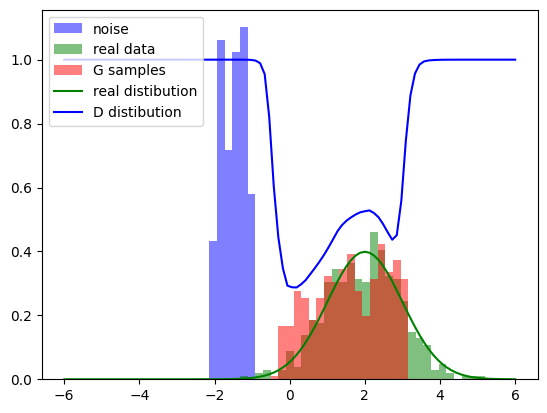

Epoch 21/50 (16s): G=0.743, Dr=0.672, Df=0.674


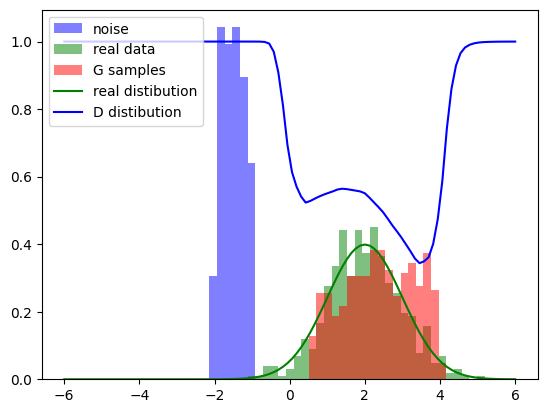

Epoch 22/50 (17s): G=0.747, Dr=0.679, Df=0.667


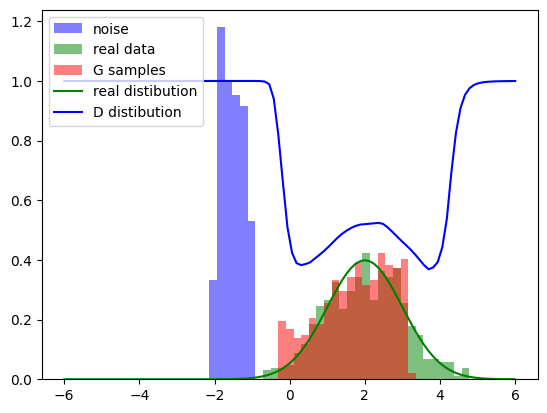

Epoch 23/50 (18s): G=0.756, Dr=0.692, Df=0.668


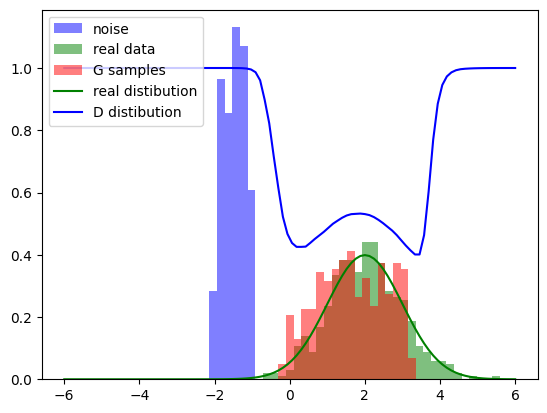

Epoch 24/50 (19s): G=0.745, Dr=0.674, Df=0.665


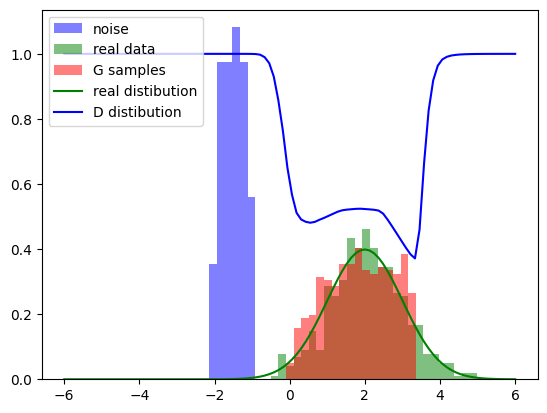

Epoch 25/50 (20s): G=0.754, Dr=0.682, Df=0.661


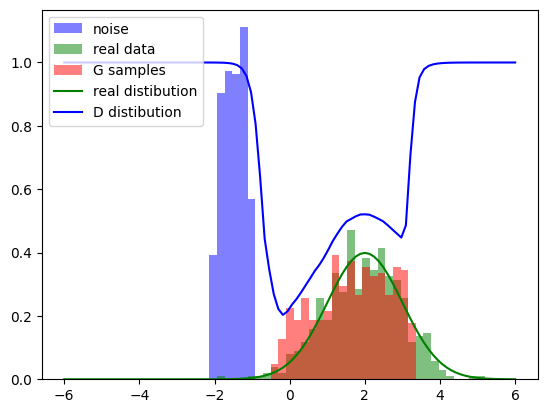

Epoch 26/50 (20s): G=0.732, Dr=0.674, Df=0.678


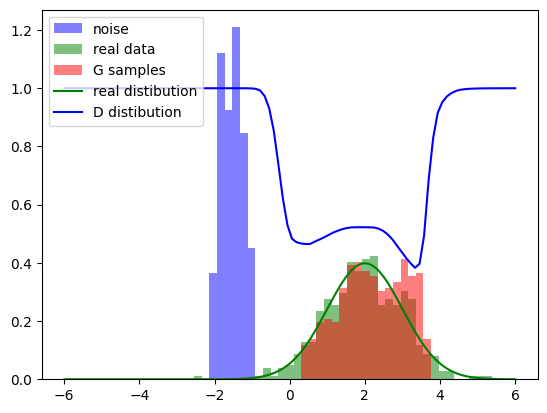

Epoch 27/50 (21s): G=0.747, Dr=0.674, Df=0.663


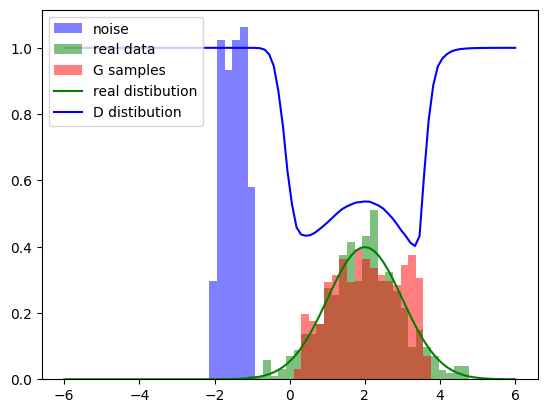

Epoch 28/50 (22s): G=0.732, Dr=0.680, Df=0.679


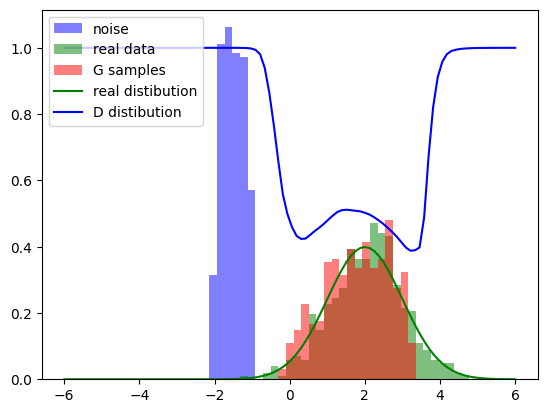

Epoch 29/50 (23s): G=0.747, Dr=0.686, Df=0.667


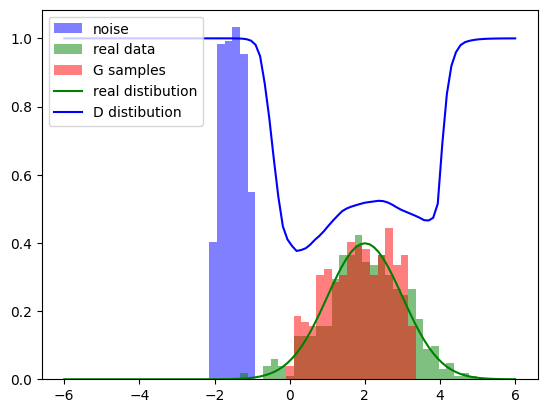

Epoch 30/50 (24s): G=0.725, Dr=0.669, Df=0.678


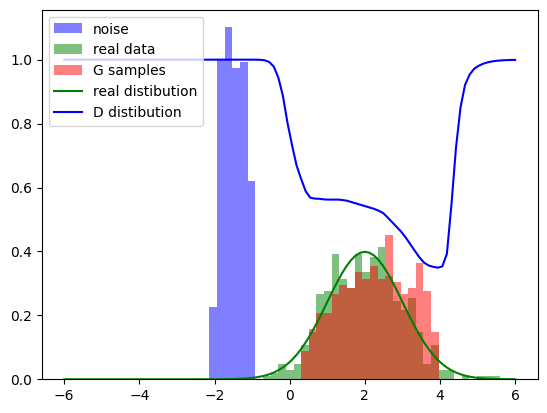

Epoch 31/50 (25s): G=0.752, Dr=0.687, Df=0.667


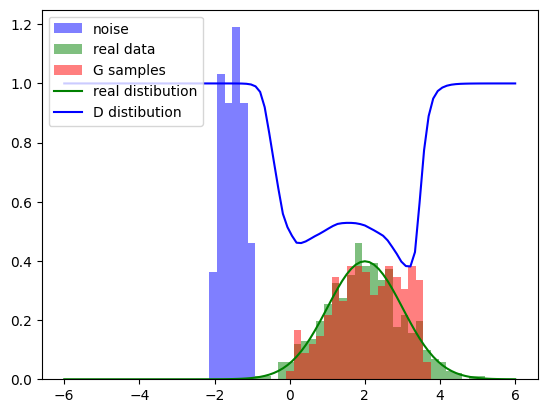

Epoch 32/50 (25s): G=0.753, Dr=0.687, Df=0.666


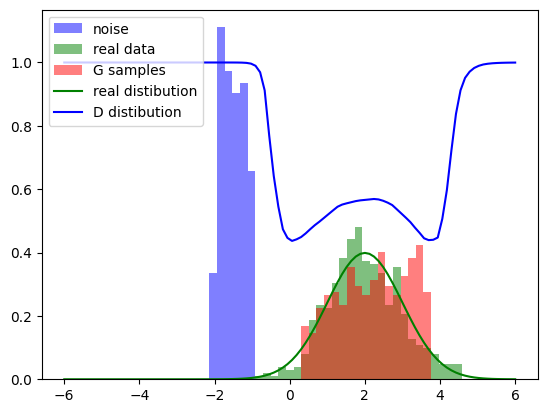

Epoch 33/50 (26s): G=0.719, Dr=0.672, Df=0.682


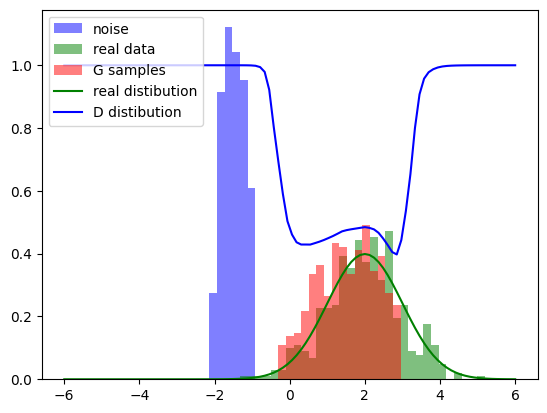

Epoch 34/50 (27s): G=0.755, Dr=0.676, Df=0.657


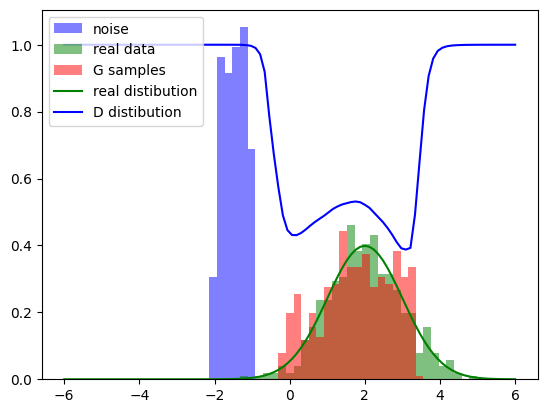

Epoch 35/50 (28s): G=0.746, Dr=0.678, Df=0.663


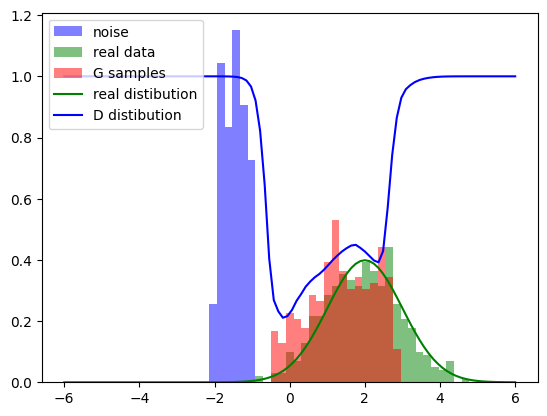

Epoch 36/50 (29s): G=0.727, Dr=0.674, Df=0.680


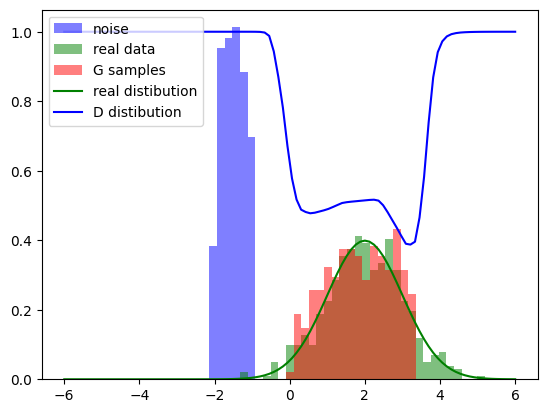

Epoch 37/50 (30s): G=0.754, Dr=0.684, Df=0.665


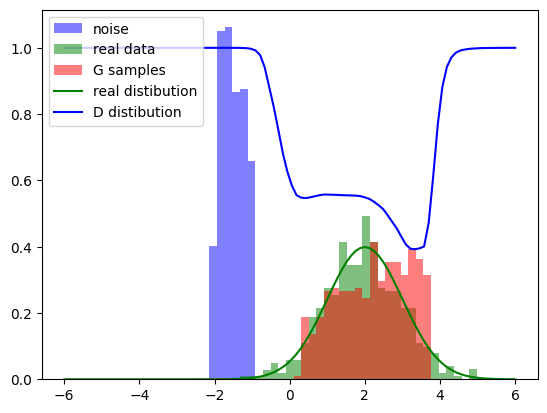

Epoch 38/50 (31s): G=0.733, Dr=0.677, Df=0.673


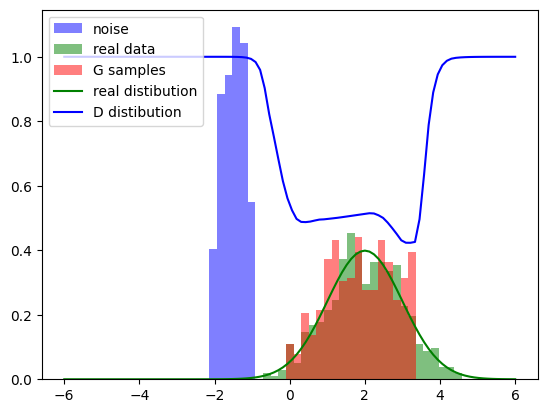

Epoch 39/50 (31s): G=0.737, Dr=0.683, Df=0.671


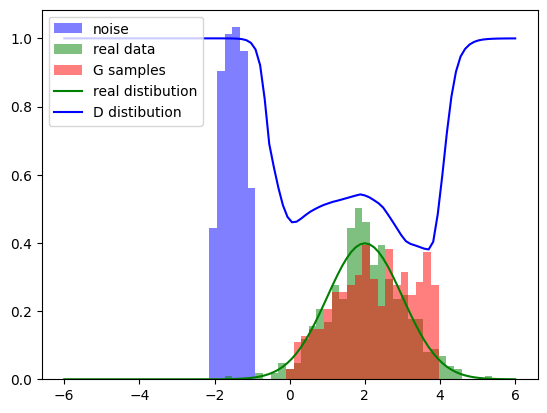

Epoch 40/50 (32s): G=0.741, Dr=0.683, Df=0.668


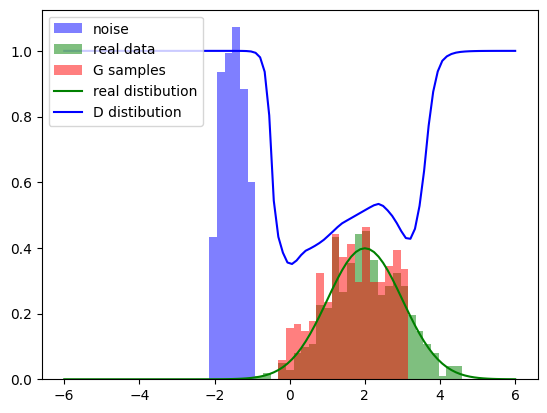

Epoch 41/50 (33s): G=0.726, Dr=0.674, Df=0.677


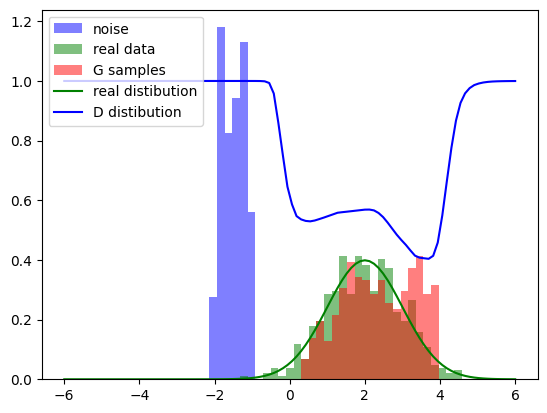

Epoch 42/50 (34s): G=0.741, Dr=0.675, Df=0.680


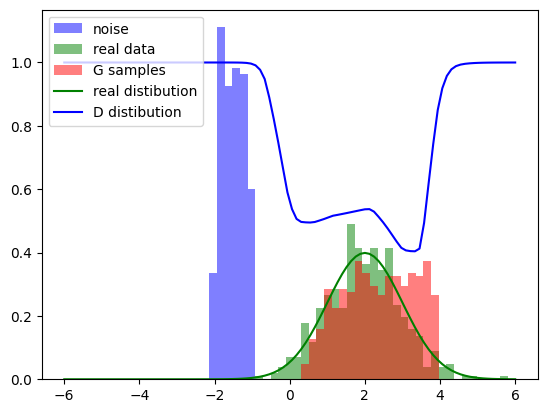

Epoch 43/50 (35s): G=0.743, Dr=0.693, Df=0.670


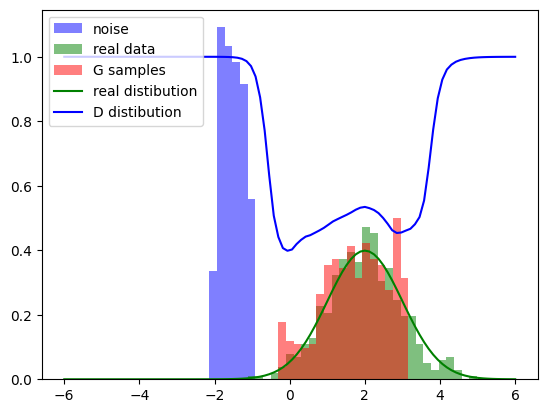

Epoch 44/50 (35s): G=0.717, Dr=0.666, Df=0.682


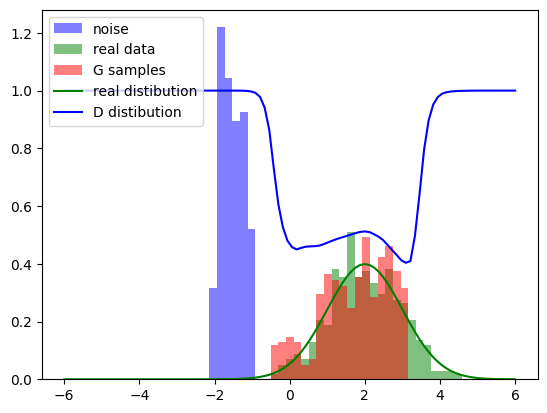

Epoch 45/50 (36s): G=0.763, Dr=0.691, Df=0.659


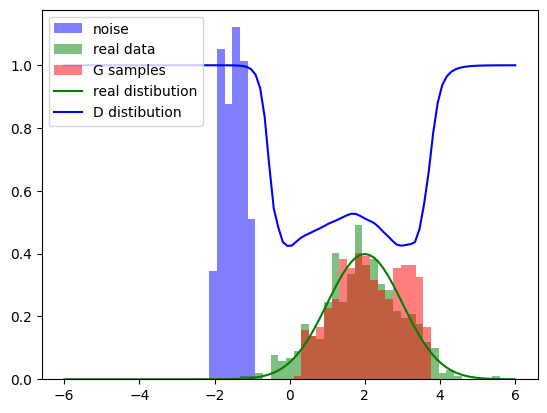

Epoch 46/50 (37s): G=0.716, Dr=0.674, Df=0.682


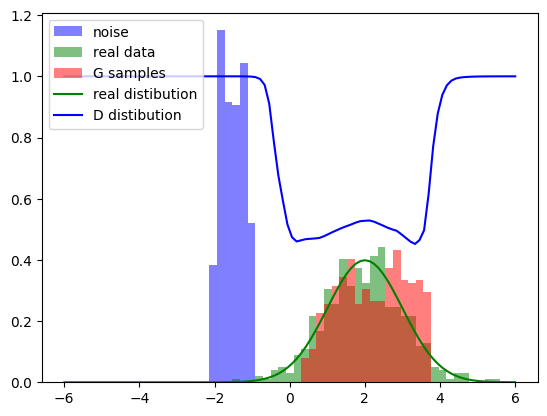

Epoch 47/50 (38s): G=0.741, Dr=0.686, Df=0.674


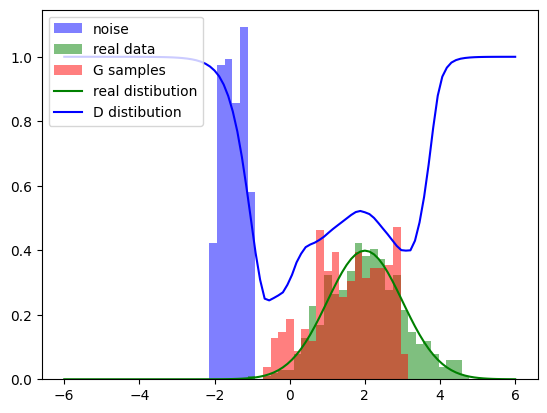

Epoch 48/50 (39s): G=0.738, Dr=0.674, Df=0.672


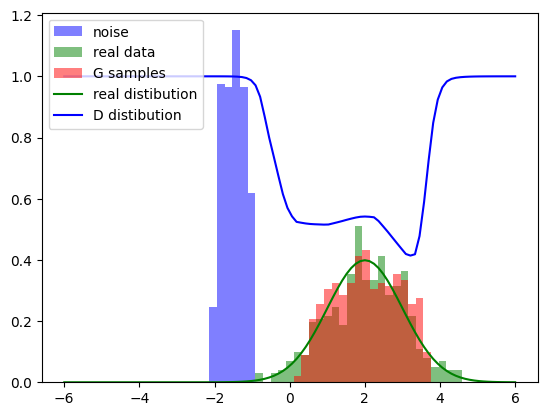

Epoch 49/50 (40s): G=0.736, Dr=0.675, Df=0.675


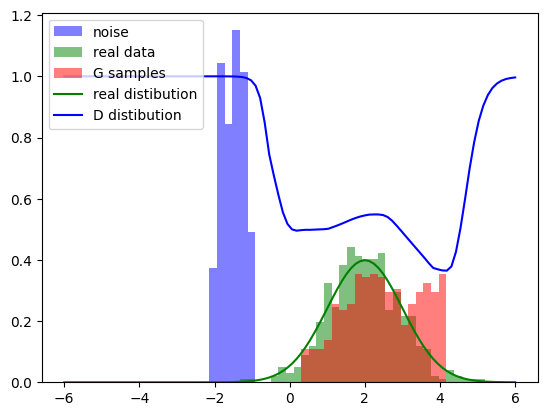

Epoch 50/50 (41s): G=0.718, Dr=0.675, Df=0.683


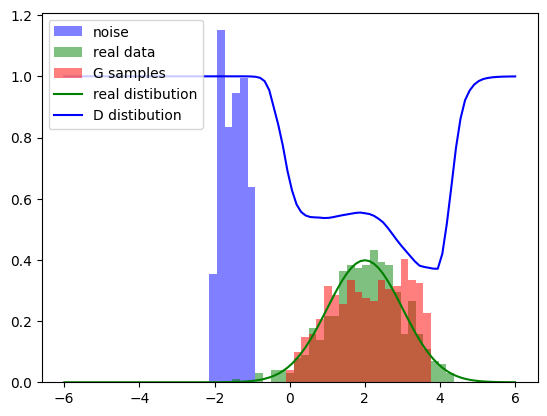

In [23]:
step_size = 1
loss_g, loss_d_real, loss_d_fake = [], [], []
start = time()
for epoch in range(epochs):
    # break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        #lg_, (ldr_, ldf_) = gan.train_step()
        ldr_, ldf_ = gan.train_step_D()
        # if i%step_size == 0:
        #     print(i)
        #     print('D train step')
        #     visualize_GAN(gan)
        lg_ = gan.train_step_G()
        # if i%step_size == 0:
        #     print('G train step')
        #     visualize_GAN(gan)

        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

In [18]:
######

In [19]:
noise_fn = lambda x: torch.rand((x, 1), device='cpu') - 0.5

pi = torch.tensor([0.7, 0.3])
mu = torch.tensor([-3., 3.])
scale = torch.tensor([1., 1.])

mixture_gaussian = TD.MixtureSameFamily(TD.Categorical(pi), TD.Normal(mu, scale))

def data_fn(x):
    return mixture_gaussian.sample((x, 1))

def data_pdf(x):
    return mixture_gaussian.log_prob(torch.tensor(x)).exp().numpy()

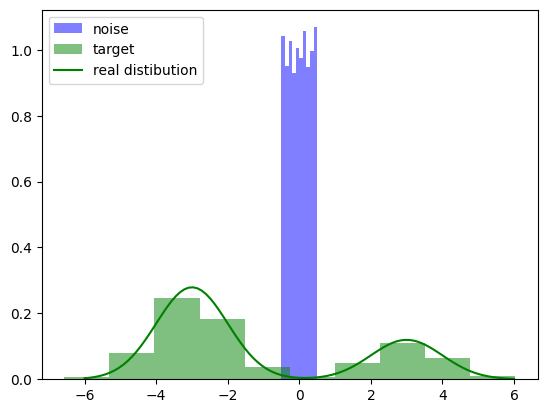

In [20]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [21]:
gen_hiddens = [1, 64, 64, 64, 1]
dis_hiddens = [1, 64, 64, 64, 1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')
loss_g, loss_d_real, loss_d_fake = [], [], []

In [22]:
epochs = 20
batches = 100

Epoch 1/20 (0s): G=2.040, Dr=0.142, Df=0.274


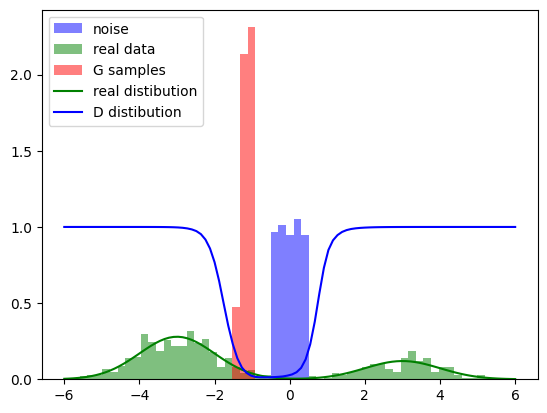

Epoch 2/20 (1s): G=1.564, Dr=0.522, Df=0.303


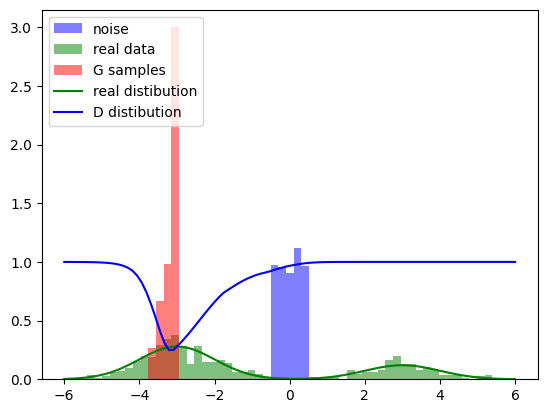

Epoch 3/20 (2s): G=1.291, Dr=0.489, Df=0.360


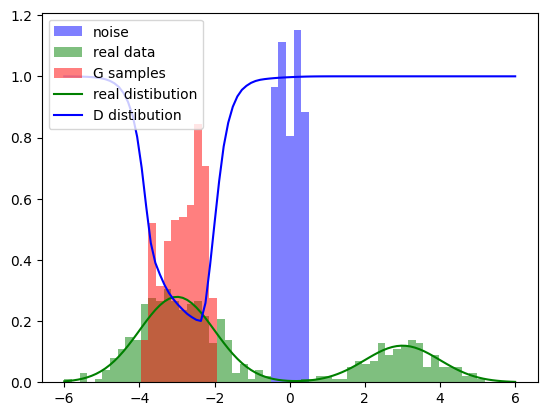

Epoch 4/20 (3s): G=1.058, Dr=0.584, Df=0.462


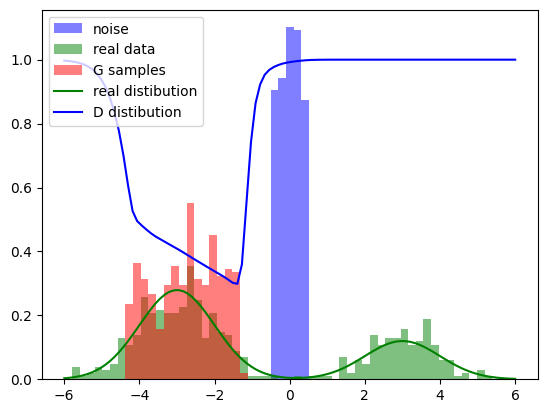

Epoch 5/20 (3s): G=0.942, Dr=0.607, Df=0.513


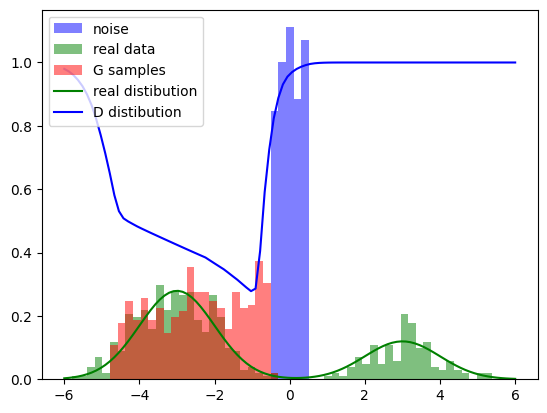

Epoch 6/20 (4s): G=0.958, Dr=0.613, Df=0.517


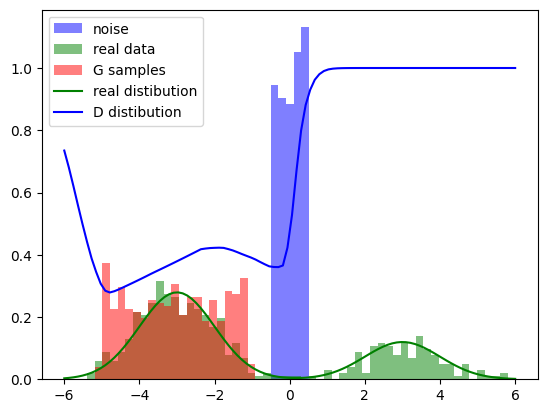

Epoch 7/20 (5s): G=0.914, Dr=0.616, Df=0.521


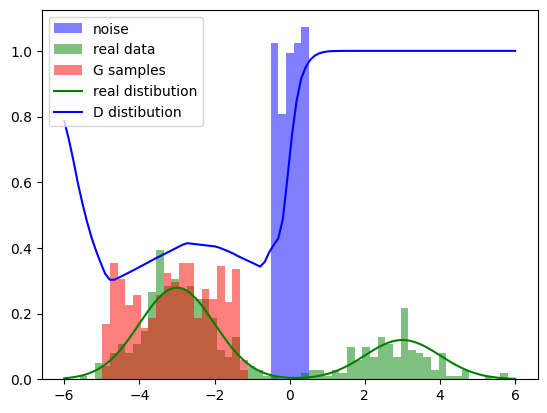

Epoch 8/20 (6s): G=0.903, Dr=0.623, Df=0.523


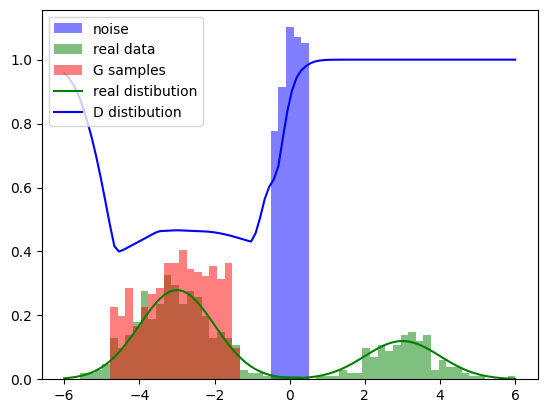

Epoch 9/20 (7s): G=0.903, Dr=0.612, Df=0.525


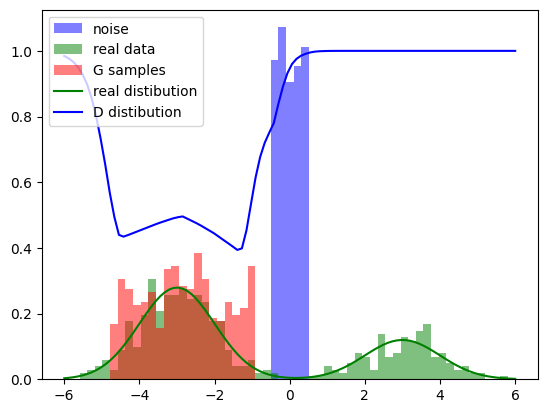

Epoch 10/20 (8s): G=0.919, Dr=0.610, Df=0.523


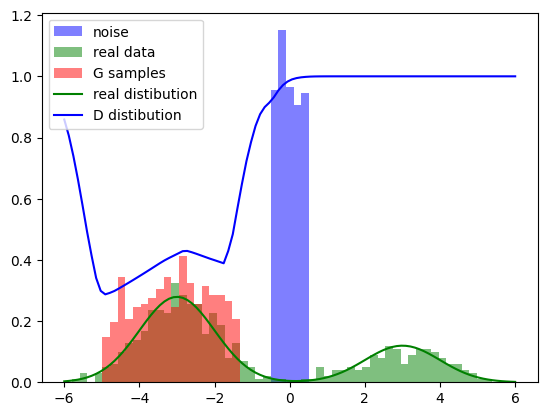

Epoch 11/20 (9s): G=0.915, Dr=0.612, Df=0.524


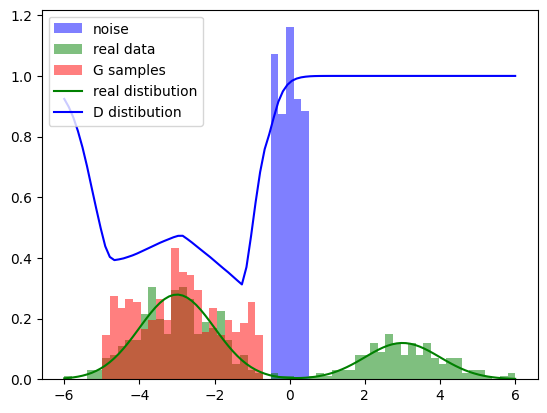

Epoch 12/20 (9s): G=0.914, Dr=0.620, Df=0.523


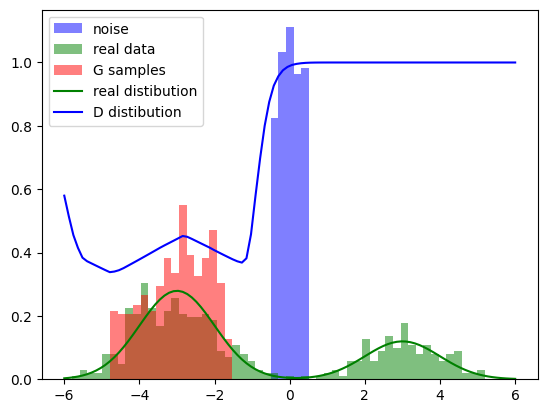

Epoch 13/20 (10s): G=0.915, Dr=0.614, Df=0.526


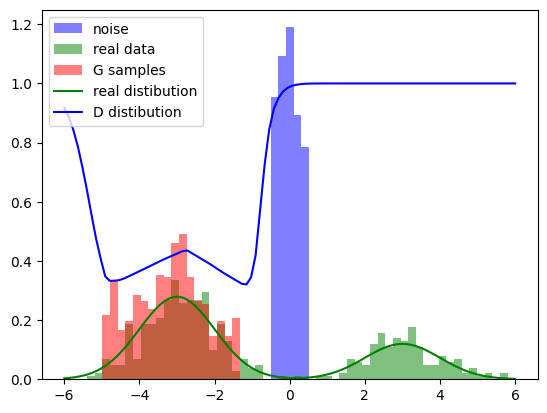

Epoch 14/20 (11s): G=0.910, Dr=0.615, Df=0.523


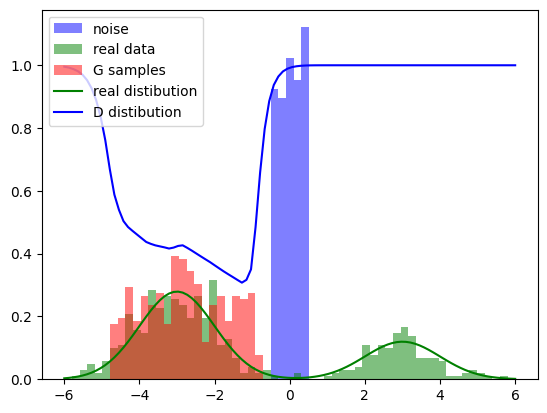

Epoch 15/20 (12s): G=0.928, Dr=0.612, Df=0.525


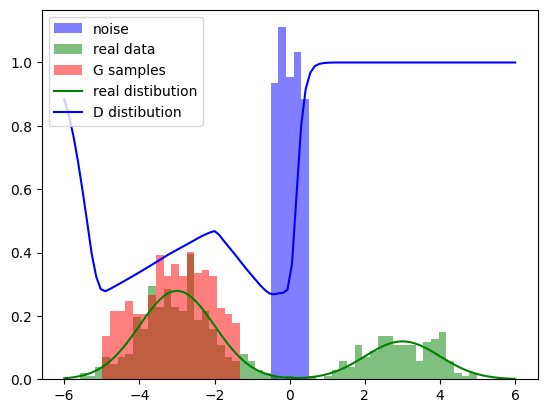

Epoch 16/20 (13s): G=0.903, Dr=0.629, Df=0.533


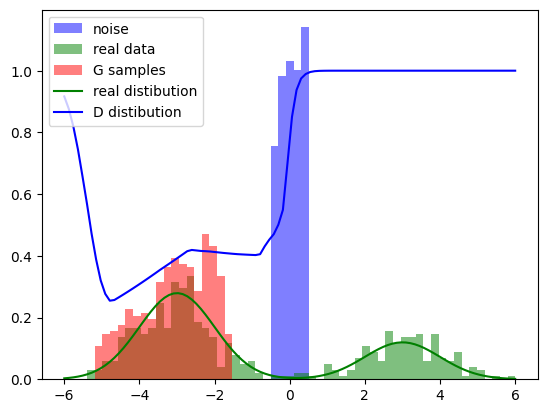

Epoch 17/20 (14s): G=0.907, Dr=0.613, Df=0.523


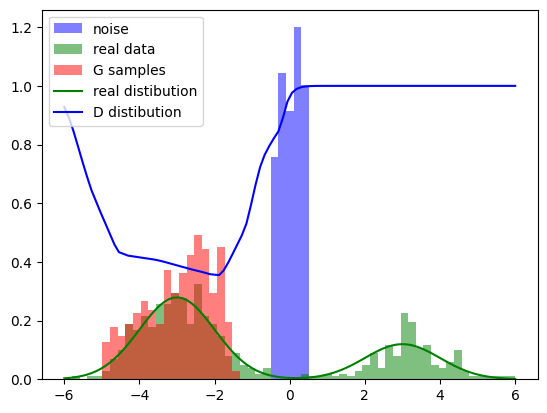

Epoch 18/20 (15s): G=0.931, Dr=0.597, Df=0.523


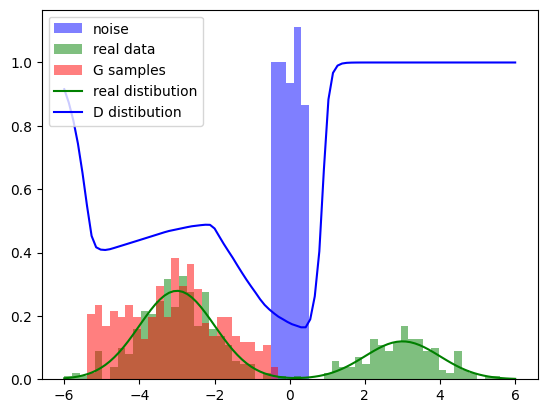

Epoch 19/20 (16s): G=0.907, Dr=0.631, Df=0.529


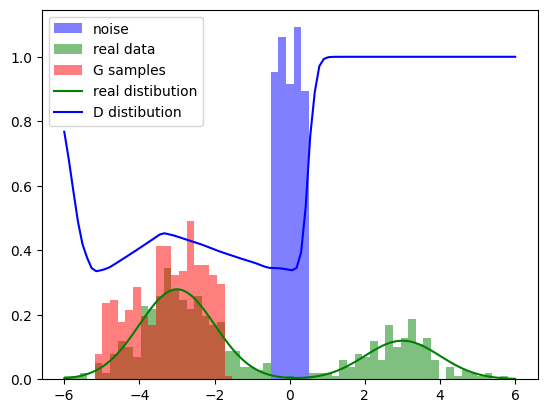

Epoch 20/20 (16s): G=0.917, Dr=0.620, Df=0.514


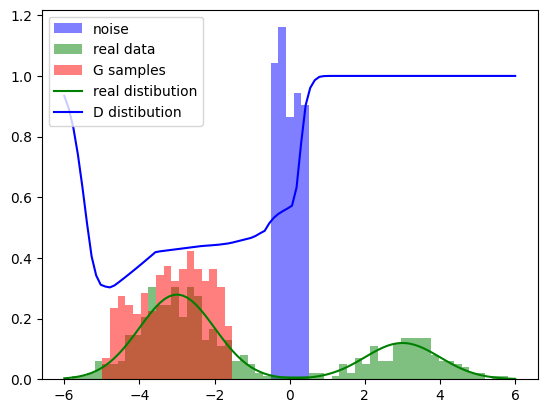

In [24]:
start = time()
for epoch in range(epochs):
    # break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)